In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from binet import binet, Number, random_matrix
import time

In [3]:
def reset_number_counter() -> None:
    Number.add_count = 0
    Number.sub_count = 0
    Number.mul_count = 0
    Number.div_count = 0

In [4]:
type operation_count = tuple[int, int, int, int]

def analyse_matmul(A: np.ndarray, B: np.ndarray) -> tuple[operation_count, float]:
    start = time.time()
    binet(A, B)
    duration = time.time() - start

    ops = Number.add_count, Number.sub_count, Number.mul_count, Number.div_count
    reset_number_counter()

    return ops, duration

In [5]:
df = pd.DataFrame(columns=["A.size", "B.size", "Time", "Additions", "Subtractions", "Multiplications", "Divisions"])

for i in range(1, 200, 10):
    A = random_matrix(i)
    B = random_matrix(i)

    (add, sub, mul, div), duration = analyse_matmul(A, B)
    df.loc[i - 1] = {"A.size": A.shape[0], "B.size": B.shape[0], "Time": duration, "Additions": add, "Subtractions": sub, "Multiplications": mul, "Divisions": div}
df

,A.size,B.size,Time,Additions,Subtractions,Multiplications,Divisions
0,1,1,0.000027,0,0,1,0
10,11,11,0.004267,1210,0,1331,0
20,21,21,0.034256,8820,0,9261,0
30,31,31,0.053025,28830,0,29791,0
40,41,41,0.143857,67240,0,68921,0
50,51,51,0.207125,130050,0,132651,0
60,61,61,0.263077,223260,0,226981,0
70,71,71,0.399072,352870,0,357911,0
80,81,81,0.742644,524880,0,531441,0
90,91,91,1.192459,745290,0,753571,0


Text(0, 0.5, 'Time [s]')

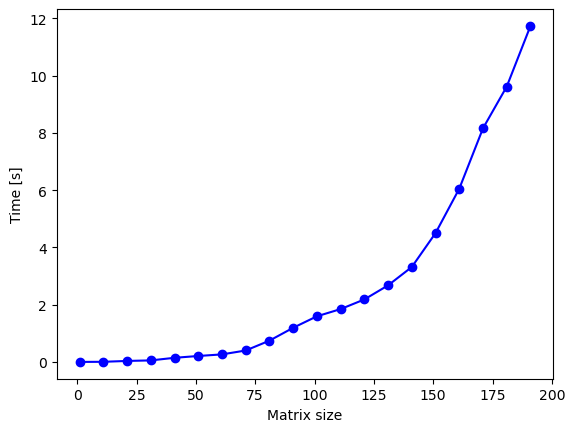

In [11]:
X = df["A.size"]

plt.plot(X, df["Time"], marker="o", color="blue", label="Multiplication time")
plt.xlabel("Matrix size")
plt.ylabel("Time [s]")

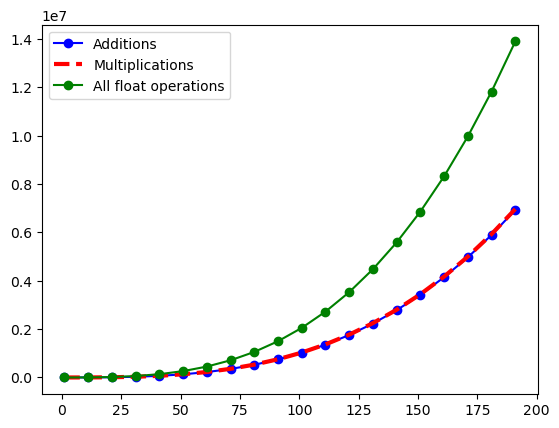

In [22]:
plt.plot(X, df["Additions"], marker="o", color="blue", label="Additions")
plt.plot(X, df["Multiplications"], color="red", label="Multiplications", linewidth=3, linestyle="--")
plt.plot(X, df["Additions"] + df["Multiplications"], color="green", marker="o", label="All float operations")

plt.legend()